<a href="https://colab.research.google.com/github/OPCoderman/GDA/blob/main/GDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.widgets import Button
import matplotlib.gridspec as gridspec

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic tumor data
def generate_tumor_data(n_samples=100, separation=2.5, noise=1.0):
    """
    Generate synthetic tumor data with two classes: benign (0) and malignant (1)

    Parameters:
    -----------
    n_samples : int
        Number of samples per class
    separation : float
        Distance between class means
    noise : float
        Standard deviation of the Gaussian noise

    Returns:
    --------
    X : ndarray of shape (2*n_samples, 2)
        Feature matrix containing size and texture
    y : ndarray of shape (2*n_samples,)
        Target vector with 0 for benign and 1 for malignant
    """
    # Benign tumors (smaller size, smoother texture)
    benign_mean = np.array([2.0, 3.0])
    benign_cov = np.array([[noise, 0.3*noise],
                          [0.3*noise, noise]])

    # Malignant tumors (larger size, rougher texture)
    malignant_mean = benign_mean + np.array([separation, separation])
    malignant_cov = np.array([[2*noise, -0.5*noise],
                             [-0.5*noise, 1.5*noise]])

    # Generate samples
    X_benign = np.random.multivariate_normal(benign_mean, benign_cov, n_samples)
    X_malignant = np.random.multivariate_normal(malignant_mean, malignant_cov, n_samples)

    # Combine data
    X = np.vstack([X_benign, X_malignant])
    y = np.hstack([np.zeros(n_samples), np.ones(n_samples)])

    return X, y

In [4]:
# TODO: Students need to implement this class
class GaussianDiscriminantAnalysis:
    """
    Gaussian Discriminant Analysis (GDA) classifier

    This is a generative model that assumes the features for each class
    are drawn from a multivariate Gaussian distribution.
    """

    def __init__(self):
        """Initialize GDA parameters"""
        self.phi = None  # Class prior P(y=1)
        self.mu0 = None  # Mean vector for class 0
        self.mu1 = None  # Mean vector for class 1
        self.sigma = None  # Shared covariance matrix

    def fit(self, X, y):
        """
        Fit the GDA model to the training data

        Parameters:
        -----------
        X : ndarray of shape (n_samples, n_features)
            Training data
        y : ndarray of shape (n_samples,)
            Target values (0 or 1)

        Returns:
        --------
        self : object
            Returns self
        """
        n_samples, n_features = X.shape

        # TODO: Compute the class prior (phi)
        # Hint: This is the proportion of samples that belong to class 1
        self.phi = np.mean(y == 1)

        # TODO: Compute the mean vectors for each class
        # Hint: mu0 is the mean of all samples where y=0, mu1 is the mean of all samples where y=1
        self.mu0 = np.mean(X[y == 0], axis=0)
        self.mu1 = np.mean(X[y == 1], axis=0)

        # TODO: Compute the shared covariance matrix
        # Hint: This is a weighted average of the covariance matrices for each class
        n0 = X[y == 0] - self.mu0
        n1 = X[y == 1] - self.mu1
        print(n0.shape,n1.shape)


        # Compute class covariances
        sigma0 = np.dot(n0.T, n0)
        sigma1 = np.dot(n1.T, n1)
        print(sigma0.shape,sigma1.shape)

        # Compute shared covariance
        self.sigma = (sigma0 + sigma1) / n_samples

        return self


    def predict_proba(self, X):
        """
        Compute posterior probabilities P(y=k|x) for each sample

        Parameters:
        -----------
        X : ndarray of shape (n_samples, n_features)
            Test data

        Returns:
        --------
        probas : ndarray of shape (n_samples, 2)
            Posterior probabilities for each class
        """
        # TODO: Implement the prediction formula based on Bayes rule
        # Hint: Use the multivariate Gaussian PDF formula

        # Compute the inverse of the covariance matrix and its determinant
        sigma_inv = np.linalg.inv(self.sigma)
        sigma_det = np.linalg.det(self.sigma)

        # Compute log probabilities for each class to avoid numerical issues
        # First, calculate the exponent terms
        def mvn_log_pdf(x, mu):
            """Log PDF of multivariate normal distribution"""
            diff = x - mu
            exponent = -0.5 * np.sum(diff @ sigma_inv * diff, axis=1)
            normalizer = -0.5 * (X.shape[1] * np.log(2 * np.pi) + np.log(sigma_det))
            return exponent + normalizer

        # Compute log likelihoods
        log_prob_0 = mvn_log_pdf(X, self.mu0) + np.log(1 - self.phi)
        log_prob_1 = mvn_log_pdf(X, self.mu1) + np.log(self.phi)

        # Compute posterior probabilities
        log_sum = np.logaddexp(log_prob_0, log_prob_1)
        prob_0 = np.exp(log_prob_0 - log_sum)
        prob_1 = np.exp(log_prob_1 - log_sum)

        return np.column_stack((prob_0, prob_1))

    def predict(self, X):
        """
        Predict class labels for samples in X

        Parameters:
        -----------
        X : ndarray of shape (n_samples, n_features)
            Test data

        Returns:
        --------
        y_pred : ndarray of shape (n_samples,)
            Predicted class labels (0 or 1)
        """
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

    def decision_boundary(self, x1, x2):
        """
        Evaluate the decision boundary on a grid

        Parameters:
        -----------
        x1 : ndarray
            Grid values for the first feature
        x2 : ndarray
            Grid values for the second feature

        Returns:
        --------
        Z : ndarray
            Decision values on the grid
        """
        # Create a grid of points
        xx, yy = np.meshgrid(x1, x2)

        # Flatten the grid points
        grid_points = np.c_[xx.ravel(), yy.ravel()]

        # Get probabilities
        probs = self.predict_proba(grid_points)[:, 1]

        # Reshape to match the grid
        Z = probs.reshape(xx.shape)

        return Z


# Initialize the plot
def plot_data_and_model(X, y, model=None, separation=2.5, noise=1.0):
    """Plot the data and optionally the decision boundary of a trained model"""

    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[5, 1])

    # Create main scatter plot
    ax = plt.subplot(gs[0, :])

    # Set axis labels and title
    ax.set_xlabel('Feature 1 (Tumor Size)', fontsize=12)
    ax.set_ylabel('Feature 2 (Texture Roughness)', fontsize=12)
    ax.set_title('Gaussian Discriminant Analysis for Tumor Classification', fontsize=14)

    # Plot the data points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['blue', 'red']),
                alpha=0.7, s=50, edgecolor='k')

    # Add a legend
    legend_labels = ['Benign', 'Malignant']
    legend = ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels,
                     loc="upper right", title="Tumor Type")

    # Plot decision boundary if model is provided
    if model is not None:
        # Create a grid to evaluate model
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx = np.linspace(x_min, x_max, 200)
        yy = np.linspace(y_min, y_max, 200)

        # Get decision boundary values
        Z = model.decision_boundary(xx, yy)

        # Plot decision boundary and margins
        cs = ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
        ax.contour(xx, yy, Z, [0.5], linewidths=2, colors='k')

        # Display contour color bar
        cbar = plt.colorbar(cs, ax=ax)
        cbar.set_label('Probability of Malignant Tumor')

        # Add mean vectors and covariance ellipses
        for i, (mean, color) in enumerate(zip([model.mu0, model.mu1], ['blue', 'red'])):
            ax.scatter(mean[0], mean[1], s=100, c=color, marker='*',
                      edgecolor='k', label=f'Mean {legend_labels[i]}')

        # Highlight covariance structure
        from matplotlib.patches import Ellipse

        def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
            """
            Plot an ellipse that represents a covariance matrix centered at position pos
            """
            v, w = np.linalg.eigh(cov)
            angle = np.degrees(np.arctan2(w[1, 0], w[0, 0]))
            width, height = 2 * nstd * np.sqrt(v)

            ell = Ellipse(xy=pos, width=width, height=height, angle=angle, **kwargs)
            ax.add_artist(ell)
            return ell

        # Plot covariance ellipses
        plot_cov_ellipse(model.sigma, model.mu0, nstd=2, ax=ax,
                        alpha=0.2, color='blue', label='Covariance')
        plot_cov_ellipse(model.sigma, model.mu1, nstd=2, ax=ax,
                        alpha=0.2, color='red')



    def refresh_plot():
        ax.clear()

        # Generate new data with updated parameters
        X_new, y_new = generate_tumor_data(n_samples=100, separation=separation, noise=noise)

        # Plot new data
        scatter = ax.scatter(X_new[:, 0], X_new[:, 1], c=y_new,
                           cmap=ListedColormap(['blue', 'red']),
                           alpha=0.7, s=50, edgecolor='k')

        # Add legend and labels
        ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels,
                loc="upper right", title="Tumor Type")
        ax.set_xlabel('Feature 1 (Tumor Size)', fontsize=12)
        ax.set_ylabel('Feature 2 (Texture Roughness)', fontsize=12)
        ax.set_title(f'Tumor Data (Separation: {separation:.1f}, Noise: {noise:.1f})', fontsize=14)

        # Update model if available
        if model is not None:
            model.fit(X_new, y_new)

            # Create a grid to evaluate model
            x_min, x_max = X_new[:, 0].min() - 1, X_new[:, 0].max() + 1
            y_min, y_max = X_new[:, 1].min() - 1, X_new[:, 1].max() + 1
            xx = np.linspace(x_min, x_max, 200)
            yy = np.linspace(y_min, y_max, 200)

            # Get decision boundary values
            Z = model.decision_boundary(xx, yy)

            # Plot decision boundary and margins
            cs = ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
            ax.contour(xx, yy, Z, [0.5], linewidths=2, colors='k')

            # Add mean vectors
            for i, (mean, color) in enumerate(zip([model.mu0, model.mu1], ['blue', 'red'])):
                ax.scatter(mean[0], mean[1], s=100, c=color, marker='*',
                          edgecolor='k', label=f'Mean {legend_labels[i]}')

            # Add covariance ellipses
            plot_cov_ellipse(model.sigma, model.mu0, nstd=2, ax=ax,
                            alpha=0.2, color='blue')
            plot_cov_ellipse(model.sigma, model.mu1, nstd=2, ax=ax,
                            alpha=0.2, color='red')

        fig.canvas.draw_idle()

    plt.tight_layout()
    plt.show()

    return separation, noise



(100, 2) (100, 2)
(2, 2) (2, 2)


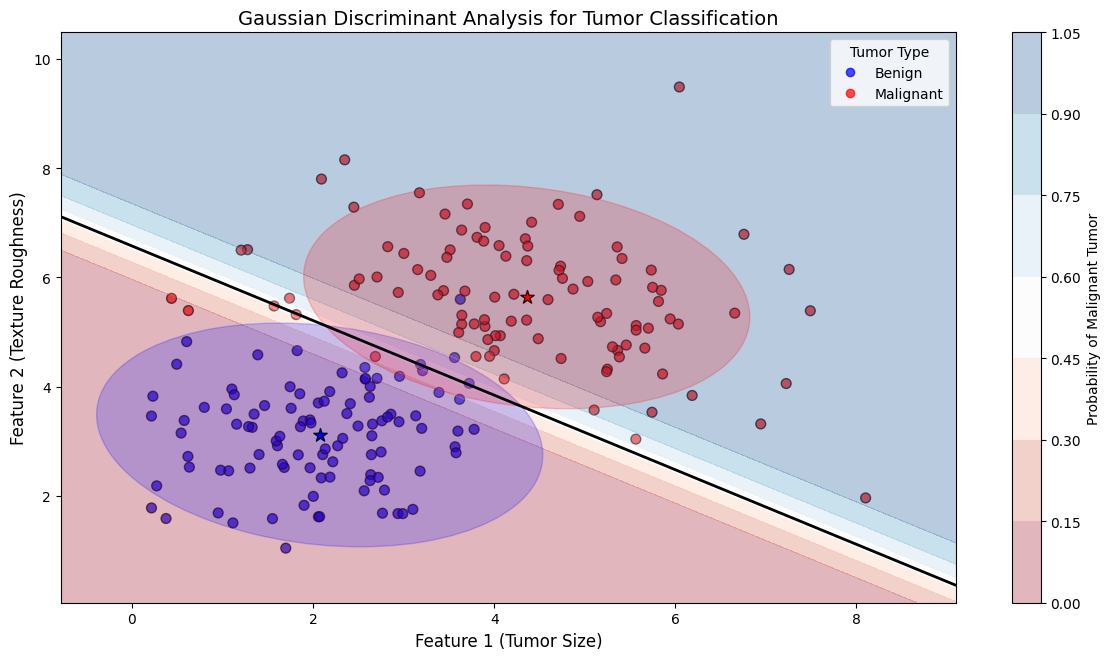

(2.5, 1.0)

In [5]:

    # Generate initial data
    X, y = generate_tumor_data(n_samples=100, separation=2.5, noise=1.0)

    # Initialize and fit the GDA model
    gda = GaussianDiscriminantAnalysis()
    gda.fit(X, y)

    # Plot data and model
    plot_data_and_model(X, y, gda)

In [ ]:
+

